In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from random import uniform
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        hidden_channle = 40
        self.net = nn.Sequential(
            nn.Linear(1, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, 1)
        )
        self.init_bias()
    def forward(self,x):
        x=self.net(x)
        return x
    def init_bias(self):
        for layer in self.net.children():
            if isinstance(layer, nn.Linear):
                # 权重采用Xavier正态初始化
                nn.init.xavier_normal_(layer.weight, gain=5 / 3)
                # 偏置置0
                nn.init.constant_(layer.bias, 0.)

In [3]:
H = 1
v_e = torch.tensor([0], dtype=torch.float32, requires_grad=True)   # 未知参数 10 ** -3
v = 10 ** -3
Epsilon = 0.4
K = 10 ** -3
g = 1
r = np.sqrt((v * Epsilon) / (10 ** (-3) * K))
def Exact_f(x, H, v, K, g, r):
    x = x.detach().numpy()
    f = g * K / v * (1 - np.cosh(r * (x - H / 2)) / np.cosh(r * H / 2))
    out = torch.tensor(f.reshape(-1, 1), dtype=torch.float32, requires_grad=True)
    return out
def gen_traindata(num):
    if num > 0:
        xvals = torch.linspace(1 / (num + 1), 1, num+1)[:-1]
        yvals = Exact_f(xvals, H = H, v = v, K = K, g = g, r = r)

        return np.reshape(xvals.numpy(), (-1, 1)), np.reshape(yvals.detach().numpy(), (-1, 1))
    else:
        return

def du_dx(x):
    x = x.detach().numpy()
    return g * K / v * (-r * np.sinh(r * (x - H / 2)) / np.cosh(r * H / 2))

def u_function(x):
    u = model(x)
    return u

def f_function(x, v, v_e, Epsilon, K ,g):     # v_e 未知
    u = u_function(x)
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
    u_xxx = torch.autograd.grad(u_xx, x, torch.ones_like(u_xx), retain_graph=True, create_graph=True)[0]
    f = -v_e / Epsilon * u_xx + v * u / K - g
    df = -v_e / Epsilon * u_xxx + v * u_x / K
    return f, df

def Loss(u, x_u, x_f, v, Epsilon, K, g, H, w = 0.01):
    f_pre, df_pre = f_function(x_f, v, v_e, Epsilon, K ,g)
    null =  torch.zeros((x_f.shape[0], 1))
    f_loss = loss_fn(f_pre, null)   # 内点loss
    df_loss = loss_fn(df_pre, null)  # gloss
    
    u_pre = u_function(x_u)
    u_loss = loss_fn(u_pre,u)   # 配置点loss
    
    ls = f_loss  + u_loss + w * df_loss
    ls.backward()
    return ls, v_e

[Epoch 1/2000] [loss: 0.5096347332000732]
[Epoch 101/2000] [loss: 0.07964697480201721]
[Epoch 201/2000] [loss: 0.06348776817321777]
[Epoch 301/2000] [loss: 0.053592249751091]
[Epoch 401/2000] [loss: 0.0433078296482563]
[Epoch 501/2000] [loss: 0.025442564859986305]
[Epoch 601/2000] [loss: 0.008716855198144913]
[Epoch 701/2000] [loss: 0.003526506945490837]
[Epoch 801/2000] [loss: 0.001845062244683504]
[Epoch 901/2000] [loss: 0.0019253278151154518]
[Epoch 1001/2000] [loss: 0.0008357593324035406]
[Epoch 1101/2000] [loss: 0.0005609093932434916]
[Epoch 1201/2000] [loss: 0.00041536279604770243]
[Epoch 1301/2000] [loss: 0.0003206615801900625]
[Epoch 1401/2000] [loss: 0.0002562666777521372]
[Epoch 1501/2000] [loss: 0.00021083769388496876]
[Epoch 1601/2000] [loss: 0.00017904271953739226]
[Epoch 1701/2000] [loss: 0.00015485701442230493]
[Epoch 1801/2000] [loss: 0.0001360225141979754]
[Epoch 1901/2000] [loss: 0.00012112201511627063]


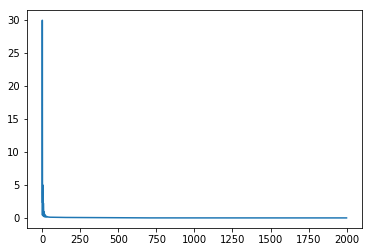

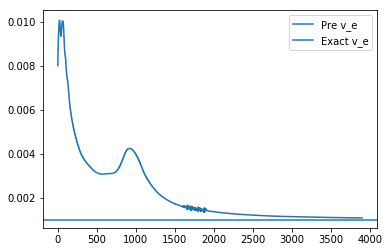

Final prediction result of v_e:  0.0010872486745938659


In [4]:
# 制造数据点集
N_f = 10000
N_u = 10
x_f = np.random.rand(N_f, 1) * H
x_f = torch.tensor(x_f.reshape(-1, 1), dtype=torch.float32, requires_grad=True)

x_u_train, u_train = gen_traindata(N_u)
x_u_train = np.vstack((x_u_train,np.reshape([0,1],(-1,1))))
u_train = np.vstack((u_train,np.reshape([0,0],(-1,1))))

x_u = torch.tensor(x_u_train.reshape(-1, 1), dtype=torch.float32, requires_grad=True)
u = torch.tensor(u_train.reshape(-1, 1), dtype=torch.float32, requires_grad=True)

x_f = torch.vstack((x_f, x_u))
# 模型训练
model=MLP()
loss_fn = nn.MSELoss()  #均方差做损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer_v_e = torch.optim.Adam([v_e], lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9, verbose=False) # 动态递减学习率
scheduler_v_e = torch.optim.lr_scheduler.StepLR(optimizer_v_e, step_size=500, gamma=0.1, verbose=False) # 动态递减学习率
epochs = 2000
Losses = []
v_e_pre = []
for epoch in range(epochs):
    optimizer.zero_grad()
    optimizer_v_e.zero_grad()
    loss, v_e = Loss(u, x_u, x_f, v, Epsilon, K, g, H)
    Losses.append(loss.item())
    v_e_pre.append(v_e.item())
    if epoch % 100 ==0:
        print(f"[Epoch {epoch+1}/{epochs}] [loss: {loss.item()}]")
    optimizer.step()
    optimizer_v_e.step()
    scheduler.step()
    scheduler_v_e.step()
    v_e_pre.append(v_e.item())
plt.plot(Losses)
plt.show()
plt.plot(v_e_pre[100:],label='Pre v_e')
plt.axhline(y=1e-3,label='Exact v_e')
plt.legend()
plt.show()
print('Final prediction result of v_e: ',v_e_pre[-1])

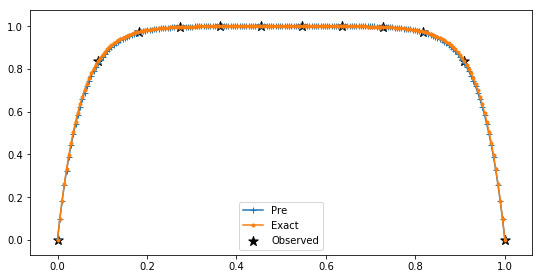

In [5]:
# 可视化
x = torch.linspace(0, 1, 200, dtype=torch.float32).reshape(-1,1).requires_grad_()
u_pre = u_function(x)
u_pre = u_pre.reshape(-1,1)
u_exact = Exact_f(x, H = H, v = v, K = K, g = g, r = r)
xnp = x.detach().numpy()
Unp = u_pre.detach().numpy()
Uex = u_exact.detach().numpy()
# plot:
fig = plt.figure(figsize=(9, 4.5))
ax = fig.add_subplot(111)
plt.plot(xnp,Unp,marker='+',label='Pre')
plt.plot(xnp,Uex,marker='.',label='Exact')
plt.scatter(x_u_train, u_train, marker='*', c='black', s=100, label='Observed')
plt.legend()
plt.show()